## Wordle

Basic EDA for a daily sample of Wordle results [tweets](https://www.kaggle.com/datasets/benhamner/wordle-tweets). Make sure to download the tweets data, and save the unzipped csv file into this repo's data folder (i.e. `./data/tweets.csv`) before running this notebook. Any new Wordle words need to be mapped for analyses.

In [1]:
from IPython.display import Image

Image(url="image/wordle.png", width=300)
# can also insert as markdown: ![wordle](image/wordle.png)

### Imports

In [2]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import re

### Read in data

In [3]:
df_tweets = pd.read_csv('data/tweets.csv')
df_tweets.info()

FileNotFoundError: [Errno 2] No such file or directory: 'data/tweets.csv'

In [ ]:
df_tweets['tweet_date'] = pd.to_datetime(df_tweets['tweet_date'])
df_tweets['tweet_date_only'] = df_tweets['tweet_date'].dt.date
df_tweets['n_attempts'] = df_tweets['tweet_text'].str[11].astype('int')

# make each tweet consistent
df_tweets['tweet_text'] = df_tweets['tweet_text'].str.replace('⬜','⬛')
# parse each guess
for n in range(6):
    n += 1
    # figure out if it even has a guess
    df_tweets[f'has_guess{n}'] = \
        df_tweets['tweet_text'].str.split('\n') \
            .str[n + 1].str.contains('|'.join(['🟨','⬛','🟩'])) \
            .fillna(False)
    
    # Add the text if it's a guess
    df_tweets.loc[df_tweets[f'has_guess{n}'], f'guess{n}'] = \
        df_tweets['tweet_text'].str.split('\n').str[n + 1].str[:5]
    
    df_tweets.loc[df_tweets[f'has_guess{n}'],
               f'guess{n}_incorrect'] = df_tweets[f'guess{n}'].str.count('⬛')
    df_tweets.loc[df_tweets[f'has_guess{n}'],
               f'guess{n}_wrong_spot'] = df_tweets[f'guess{n}'].str.count('🟨')
    df_tweets.loc[df_tweets[f'has_guess{n}'],
               f'guess{n}_correct'] = df_tweets[f'guess{n}'].str.count('🟩')
    df_tweets.loc[df_tweets[f'guess{n}_correct'] == 6, 'final_guess'] = n

In [4]:
df_tweets.head()

NameError: name 'df_tweets' is not defined

#### Quick look at data

In [ ]:
df_tweets.groupby("wordle_id")["wordle_id"].count()

wordle_id
210    2837
211    2894
212    2399
213    2119
214    2703
       ... 
299    3821
300    3369
301    3831
302    3698
303    3783
Name: wordle_id, Length: 92, dtype: int64

<AxesSubplot:title={'center':'Wordle Tweets by Day'}>

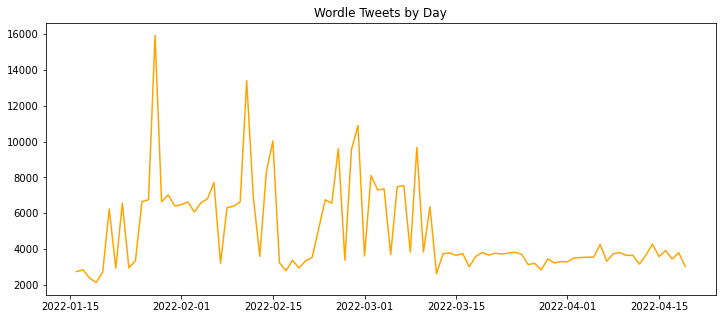

In [ ]:
df_tweets['tweet_date_only'].value_counts().plot(figsize=(12, 5), title='Wordle Tweets by Day', color='orange')

In [ ]:
df_tweets['day'] = df_tweets['tweet_date'].dt.day_name()
df_tweets.groupby(['tweet_date_only','day'])['n_attempts'].value_counts().unstack().style.background_gradient(axis=1)

In [ ]:
df_tweets.groupby('day')['n_attempts'].value_counts().unstack().style.background_gradient(axis=1)

n_attempts,2,3,4,5,6
day,,,,,
Friday,4968,19506,28421,22193,11534
Monday,4127,16482,22699,16143,7458
Saturday,3761,12565,17245,13290,7124
Sunday,3959,16905,23852,14807,6022
Thursday,3925,14641,20257,14317,7084
Tuesday,4037,14144,18542,13372,6312
Wednesday,4573,16300,22669,16433,8141


#### Map to actual words

In [ ]:
map_dict = {
        '210' : 'PANIC',
        '211' : 'SOLAR',
        '212' : 'SHIRE',
        '213' : 'PROXY',
        '214' : 'POINT',
        '215' : 'ROBOT',
        '216' : 'PRICK'}

##### h5- asdf

In [ ]:
map_dict = {int(k):str(v) for k,v in map_dict.items()}

df_tweets['answer'] = df_tweets['wordle_id'].map(map_dict)
df_tweets.groupby('answer')['n_attempts'].value_counts().unstack().style.background_gradient(axis=1)


###### h6- anothger

In [ ]:
df_tweets.groupby('answer')['n_attempts'].value_counts().unstack().style.background_gradient(axis=1)


### Analysis

<AxesSubplot:title={'center':'Number of Attempts'}>

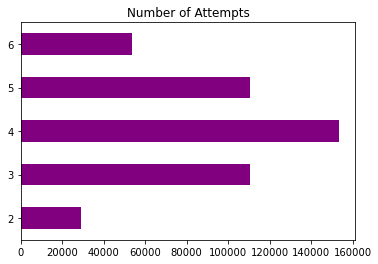

In [ ]:
df_tweets['n_attempts'].value_counts().sort_index().plot(kind='barh', title='Number of Attempts', color='purple')

<AxesSubplot:title={'center':'Most Common Correct Guessed Letters on First Try'}>

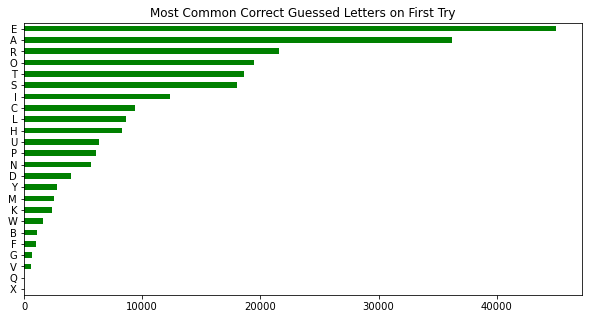

In [ ]:
# count the correctly guessed first letters
first_guess_correct = []
for i, d in df_tweets.dropna(subset=['answer']).iterrows():
    example_text = d['guess1']
    example_solution = d['answer']
    results =[x.span()[0] for x in re.finditer('🟩', example_text)]
    first_guess_letters = [example_solution[i] for i in results]
    first_guess_correct += first_guess_letters

pd.Series(first_guess_correct).value_counts(ascending=True) \
    .plot(kind='barh', figsize=(10, 5), color='green',
          title='Most Common Correct Guessed Letters on First Try')

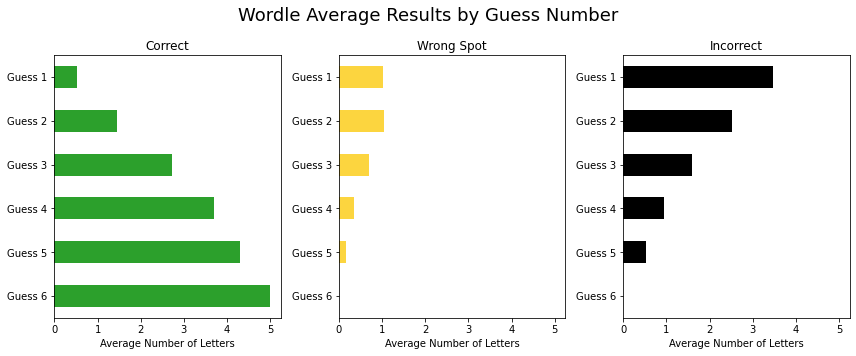

In [ ]:
color_pal = ['#2ca02c', '#fcd53f', '#000000']

fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharex=True)

for i, x in enumerate(['_correct','_wrong_spot','_incorrect']):
    col_subset = [c for c in df_tweets.columns if x in c]
    guess_avg = df_tweets[col_subset].mean()
    guess_avg.index = [f'Guess {i+1}' for i in range(6)]
    guess_avg.sort_index(ascending=False).plot(kind='barh',
              title=f'{x.strip("_").replace("_"," ").title()}',
              ax=axs[i], color=color_pal[i])
    axs[i].set_xlabel('Average Number of Letters')
fig.suptitle('Wordle Average Results by Guess Number', fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
guess1_split = df_tweets.set_index('tweet_id') \
    ['guess1'].str.split('', expand=True) \
    .drop([0, 6], axis=1)

guess1_split = guess1_split.unstack().reset_index() \
    .rename(columns={'level_0':'letter_loc',
                     0:'result'})

guess1_split.groupby('letter_loc')['result'] \
    .value_counts().unstack().T \
    .style.background_gradient()

letter_loc,1,2,3,4,5
result,,,,,
⬛,334465,304259,310049,320553,316362
🟨,79619,105911,98156,99816,85048
🟩,43724,47638,49603,37439,56398


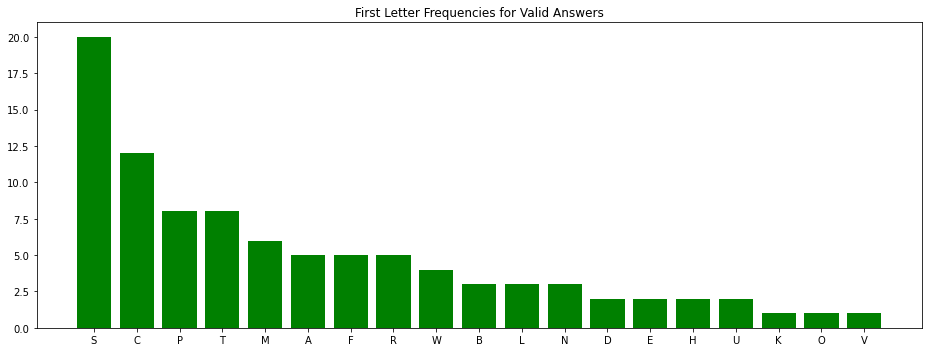

In [ ]:
word_list = [*map_dict.values()]
unique_word_list = np.unique(word_list)

first_letter_list = [word[0] for word in list(unique_word_list)]
count = Counter(first_letter_list)

plt.rc("figure", autolayout=True, figsize=(13, 5))
ax = plt.bar(*zip(*count.most_common()), color='green')
plt.title("First Letter Frequencies for Valid Answers");